In [3]:
import gc
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
import seaborn as sns
from tqdm import tqdm
import lightgbm as lgb


,id,var1,var2,var3,var4,var5,var6,var7,var8,var9,...,var60,var61,var62,var63,var64,var65,var66,var67,var68,y
0,1,18,19.0,2853.0,29442.0,1386,2435.0,35.0,NaN,3,...,0.311441,0.142303,0.056146,0.632694,0.024054,0.253356,0.00603,0.132353,0.139706,1
1,8,4,110.0,1986.0,13684.0,7189,NaN,NaN,17.0,3,...,NaN,NaN,0.070991,0.773966,0.019315,NaN,NaN,0.147059,0.106618,0
2,30,0,39.0,1019.0,10232.0,678,791.0,16.0,NaN,3,...,NaN,0.200814,0.051046,0.980827,0.018536,NaN,NaN,0.382353,0.242647,0
3,43,20,39.0,1751.0,2689.0,8235,1042.0,13.0,10.0,1,...,NaN,0.352379,0.044301,0.951564,0.023684,0.363370,0.00201,0.147059,0.132353,0
4,46,7,44.0,2262.0,29428.0,6031,304.0,16.0,NaN,3,...,0.021226,0.226161,0.059125,0.906155,0.020733,NaN,NaN,0.455882,0.132353,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14118,35295,4,39.0,2511.0,28766.0,1109,2094.0,31.0,24.0,3,...,NaN,0.069347,0.036178,0.869828,0.016160,NaN,NaN,0.455882,0.147059,0
14119,35296,19,129.0,1114.0,NaN,6376,NaN,NaN,27.0,3,...,NaN,0.295418,0.055899,0.921292,0.018293,NaN,NaN,0.147059,0.198529,0
14120,35301,27,44.0,1786.0,23761.0,9048,623.0,35.0,27.0,3,...,NaN,0.203394,0.040697,0.930373,0.009440,NaN,NaN,0.397059,0.158088,0
14121,35304,4,89.0,210.0,19593.0,3634,2453.0,35.0,27.0,1,...,0.070788,0.381038,0.100384,0.680121,0.041096,NaN,NaN,0.264706,0.128676,0


In [90]:

train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
#train = train.replace(-999, np.NAN)
#test = test.replace(-999, np.NAN)
# cat feat eng

#train["var9"][train["var9"] == -999] = 3
#test["var9"][test["var9"] == -999] = 3
#
#train = train.replace(-999, np.NAN)
#test = test.replace(-999, np.NAN)


<ipython-input-90-dea2db1ef8de>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["var9"][train["var9"] == -999] = 3
<ipython-input-90-dea2db1ef8de>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["var9"][test["var9"] == -999] = 3


In [87]:
cols_to_drop = [
    'id',
    'y',
]

14      NaN
25      NaN
26      NaN
30      NaN
32      NaN
         ..
14095   NaN
14109   NaN
14113   NaN
14115   NaN
14119   NaN
Name: var11, Length: 1719, dtype: float64

<ipython-input-73-a2ddc3b13ccd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["var11"][train["var11"].isnull()] = train["aux"][train["var11"].isnull()]
<ipython-input-73-a2ddc3b13ccd>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["var11"][test["var11"].isnull()] = test["aux"][test["var11"].isnull()]


In [80]:
test

,id,var1,var2,var3,var4,var5,var6,var7,var8,var9,...,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68
0,0,5,126.0,1353.0,28956.0,743,1289.0,27.0,NaN,1.0,...,0.201839,0.353965,0.166641,0.049108,0.986882,0.016683,NaN,NaN,0.176471,0.253676
1,2,6,126.0,1446.0,7803.0,5151,935.0,35.0,NaN,3.0,...,0.072127,0.074555,0.217009,0.144403,0.892028,0.038323,NaN,NaN,0.147059,0.099265
2,4,5,44.0,243.0,4325.0,1109,1903.0,33.0,24.0,1.0,...,0.324770,0.384992,0.330680,0.072864,0.930373,0.021052,NaN,NaN,0.294118,0.136029
3,7,4,53.0,419.0,743.0,7750,183.0,35.0,NaN,3.0,...,0.131070,NaN,0.244936,0.158088,0.986882,0.022649,NaN,NaN,0.294118,0.220588
4,15,4,126.0,1863.0,22693.0,5625,965.0,9.0,NaN,3.0,...,0.225166,0.059940,0.252794,0.080405,0.944501,0.021806,NaN,NaN,0.352941,0.113971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21178,35297,4,126.0,1460.0,13335.0,9048,620.0,35.0,27.0,3.0,...,0.148933,NaN,0.326307,0.132833,0.968718,0.039626,NaN,NaN,0.323529,0.253676
21179,35298,18,19.0,532.0,14837.0,2590,855.0,27.0,20.0,3.0,...,0.179243,0.205030,0.229354,0.052108,0.940464,0.016952,NaN,NaN,0.088235,0.209559
21180,35300,4,126.0,2923.0,16685.0,3162,1604.0,35.0,NaN,3.0,...,0.237607,0.810448,0.179781,0.029155,0.745711,0.020158,NaN,NaN,0.205882,0.161765
21181,35302,5,NaN,NaN,367.0,7637,1389.0,35.0,NaN,3.0,...,0.102662,NaN,0.149598,0.032583,0.891019,0.012596,NaN,NaN,NaN,0.246324


In [29]:
aux = pd.DataFrame(train.groupby("var18")["var2"].mean())
aux.reset_index(inplace=True)

,var18,var2
0,1.0,74.366197
1,2.0,71.296182
2,3.0,69.841578
3,4.0,69.750903
4,5.0,67.753123
5,6.0,67.835052


train.shape = (14123, 70), test.shape = (21183, 69)
Fold 1/5*1
Training until validation scores don't improve for 150 rounds
[100]	training's binary_logloss: 0.329566	training's f1: 0.438335	valid_1's binary_logloss: 0.437613	valid_1's f1: 0.534314
[200]	training's binary_logloss: 0.293761	training's f1: 0.636447	valid_1's binary_logloss: 0.397186	valid_1's f1: 0.672787
[300]	training's binary_logloss: 0.273118	training's f1: 0.661108	valid_1's binary_logloss: 0.383668	valid_1's f1: 0.688691
[400]	training's binary_logloss: 0.256712	training's f1: 0.682166	valid_1's binary_logloss: 0.375811	valid_1's f1: 0.69483
[500]	training's binary_logloss: 0.24341	training's f1: 0.696418	valid_1's binary_logloss: 0.372887	valid_1's f1: 0.700629
[600]	training's binary_logloss: 0.232409	training's f1: 0.711527	valid_1's binary_logloss: 0.371739	valid_1's f1: 0.696573
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.244952	training's f1: 0.694428	valid_1's binary_logloss: 0.3731

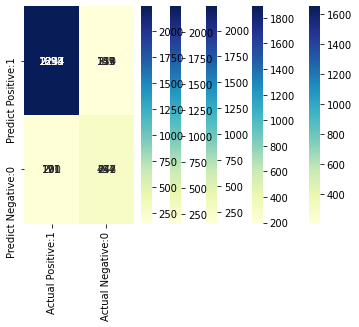

In [89]:
from sklearn.metrics import f1_score

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

confusion_m = True

X = train.drop(cols_to_drop, axis=1, errors='ignore')
y = train.y.values

X_test = test.drop(cols_to_drop, axis=1, errors='ignore')
id_test = test.id.values

print('train.shape = {}, test.shape = {}'.format(train.shape, test.shape))

lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'max_depth': 5,
    'learning_rate': 0.01, 
    'verbose': -1,
    'num_threads': 2,
}

# Build the model
cnt = 0
p_buf = []
n_splits = 5
n_repeats = 1
kf = KFold(
    n_splits=n_splits)
err_buf = []   
err2_buf = []   

n_features = X.shape[1]

for train_index, valid_index in kf.split(X, y):
    print('Fold {}/{}*{}'.format(cnt + 1, n_splits, n_repeats))
    params = lgb_params.copy() 
    evals_result = {}

    lgb_train = lgb.Dataset(
        X.iloc[train_index], 
        y[train_index], 
        )
    lgb_train.raw_data = None

    lgb_valid = lgb.Dataset(
        X.iloc[valid_index], 
        y[valid_index],
        )
    lgb_valid.raw_data = None

    model = lgb.train(
        
        params,
        lgb_train,
        num_boost_round=100000,
        valid_sets=[lgb_train, lgb_valid],
        early_stopping_rounds=150, 
        verbose_eval=100, feval=lgb_f1_score, evals_result=evals_result
    )

    if cnt == 0:
        importance = model.feature_importance()
        model_fnames = model.feature_name()
        tuples = sorted(zip(model_fnames, importance), key=lambda x: x[1])[::-1]
        tuples = [x for x in tuples if x[1] > 0]
        print('Important features:')
        for i in range(60):
            if i < len(tuples):
                print(tuples[i])
            else:
                break

        del importance, model_fnames, tuples

    p = model.predict(X.iloc[valid_index], num_iteration=model.best_iteration)

    p[p > 0.3] = 1
    p[p != 1] = 0
    if confusion_m:
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(y[valid_index], p)
        print('Confusion matrix\n\n', cm)
        print('\nTrue Positives(TP) = ', cm[0,0])
        print('\nTrue Negatives(TN) = ', cm[1,1])
        print('\nFalse Positives(FP) = ', cm[0,1])
        print('\nFalse Negatives(FN) = ', cm[1,0])
        cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                     index=['Predict Positive:1', 'Predict Negative:0'])

        sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
        
    err = f1_score(y[valid_index], p)
    p = model.predict(X.iloc[valid_index], num_iteration=model.best_iteration)

    p[p > 0.5] = 1
    p[p != 1] = 0
    err2 = f1_score(y[valid_index], p)

    print('{} f1: {}'.format(cnt + 1, err))

    p = model.predict(X_test, num_iteration=model.best_iteration)
    if len(p_buf) == 0:
        p_buf = np.array(p, dtype=np.float16)
    else:
        p_buf += np.array(p, dtype=np.float16)
    err_buf.append(err)
    err2_buf.append(err2)


    cnt += 1
    # if cnt > 0: # Comment this to run several folds
    #     break

    del model, lgb_train, lgb_valid, p
    gc.collect

err_mean = np.mean(err_buf)
err_std = np.std(err_buf)
print('f1 0.3 = {:.6f} +/- {:.6f}'.format(err_mean, err_std))
err_mean = np.mean(err2_buf)
err_std = np.std(err2_buf)
print('f1 0.5 = {:.6f} +/- {:.6f}'.format(err_mean, err_std))

preds = p_buf/cnt


In [67]:
train[train.var12.isnull()]

,id,var1,var2,var3,var4,var5,var6,var7,var8,var9,...,var60,var61,var62,var63,var64,var65,var66,var67,var68,y
11,115,18,39.0,1747.0,27314.0,801,1704.0,35.0,NaN,1,...,NaN,0.129989,0.034083,0.895055,0.015649,NaN,NaN,0.250000,0.242647,1
14,132,21,121.0,812.0,31954.0,9574,2026.0,35.0,27.0,3,...,NaN,0.169461,0.065909,0.900101,0.016160,NaN,NaN,0.250000,0.231618,1
25,244,21,126.0,1529.0,21643.0,1726,1438.0,33.0,25.0,3,...,NaN,0.353497,0.058331,0.702321,0.015776,NaN,NaN,0.161765,0.268382,1
26,266,19,129.0,3522.0,24403.0,7657,2451.0,33.0,19.0,3,...,NaN,0.255554,0.290513,0.866801,0.061841,NaN,NaN,0.279412,0.238971,0
30,317,4,44.0,539.0,30305.0,612,482.0,35.0,27.0,3,...,NaN,0.196565,0.142766,0.912210,0.018268,NaN,NaN,0.220588,0.235294,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14109,35257,22,53.0,582.0,NaN,6376,NaN,NaN,19.0,3,...,NaN,0.183044,0.090636,0.002018,0.032805,NaN,NaN,0.161765,0.069853,0
14113,35265,4,19.0,2242.0,NaN,6376,NaN,NaN,27.0,3,...,NaN,0.112558,0.026972,0.827447,0.033009,NaN,NaN,0.088235,0.084559,0
14115,35289,0,126.0,3269.0,NaN,6376,NaN,NaN,6.0,1,...,NaN,0.288989,0.051873,0.667003,0.013899,NaN,NaN,0.073529,0.238971,0
14118,35295,4,39.0,2511.0,28766.0,1109,2094.0,31.0,24.0,3,...,NaN,0.069347,0.036178,0.869828,0.016160,NaN,NaN,0.455882,0.147059,0


In [84]:
np.round(p)

array([1., 0., 0., ..., 0., 0., 0.])

In [35]:

# Prepare submission
subm = pd.DataFrame()
subm['id'] = id_test
subm['predicted'] = preds
subm['predicted'][subm['predicted'] > 0.3] = 1
subm['predicted'][subm['predicted'] != 1] = 0


<ipython-input-35-7095140c94c3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subm['predicted'][subm['predicted'] > 0.3] = 1
<ipython-input-35-7095140c94c3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subm['predicted'][subm['predicted'] != 1] = 0


In [36]:
subm['predicted'] = subm['predicted'].astype(int)
subm.to_csv('lgb03-na-diff-test.csv', index=False)